# OTA_HotelBookingRuleNotifRQ

##  analysis is done on basis of 3 files that came at 1st of December 2021 

In [276]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## Import the relevant libraries

In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re

## Load all parquet files that were available with that message

In [278]:
HotelBookingRuleNotifRQ_Messages = pd.read_parquet("Documents/ota_ugoBooking", engine='auto')
HotelBookingRuleNotifRQ_Messages

,HotelBookingRuleNotifRQ_Messages
0,[{'MessageMeta': {'X-Correlation-ID': 'ebf26fe...
1,[{'MessageMeta': {'X-Correlation-ID': '2e5300c...
2,[{'MessageMeta': {'X-Correlation-ID': '782af54...


## Create DataFrame from loaded data

### Resolving first level of nesting<hr>

In [279]:
firstLevel = []
for index, level in HotelBookingRuleNotifRQ_Messages.iterrows():
    firstLevel.extend(HotelBookingRuleNotifRQ_Messages.iloc[index,0])

### Resolving all levels of nesting<hr>

In [280]:
def resolveNestedArray(di, row_data):
    newDi = []
    for row in row_data:
        di.update(row)
        newDi.append(di)
    return newDi

def unnestFile(li, key_level=""):
    listOfUnnested = []
    for level in li:
        row_data = None
        level1 = {}
        for key, value in level.items():
            if isinstance(value, np.ndarray):
                row_data = unnestFile(value, key)
            elif isinstance(value, dict):
                level1.update(value)
            else:
                level1[key_level+"_"+ key] = value

        if row_data is not None:
            newDi = resolveNestedArray(level1, row_data)
            listOfUnnested.extend(newDi)
        else:
            listOfUnnested.append(level1)
    return listOfUnnested


def prepareForDF(firstLevel):
    levelTemp = unnestFile(firstLevel)
    while any(isinstance(n, dict) for n in levelTemp[0].values())|any(isinstance(m, np.ndarray) for m in levelTemp[0].values()):
        newL = unnestFile(levelTemp)
        levelTemp = newL
    return levelTemp              

final = prepareForDF(firstLevel)

### Creating DataFrame<hr>

In [281]:
from datetime import datetime
finalData_raw = pd.DataFrame(final)

In [282]:
finalData_raw.columns = [re.sub("^_+","",x) for x in finalData_raw.columns]
finalData_raw

,X-Correlation-ID,Type,AppId,PrimaryLangID,EchoToken,TimeStamp,Version,Target,HotelCode,ChainCode,...,RestrictionStatus_Restriction,RestrictionStatus_Status,RestrictionStatus_MinAdvancedBookingOffset,RestrictionStatus_MaxAdvancedBookingOffset,LengthOfStay_MinMaxMessageType,LengthOfStay_Time,LengthOfStay_TimeUnit,LengthOfStay_MinLOS,LengthOfStay_MaxLOS,BookingRule_RestrictionStatus
0,ebf26fe7-6823-4bdd-8fc2-0de7e9895686,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,Departure,Open,NaN,NaN,SetMaxLOS,-9999,None,None,None,NaN
1,ebf26fe7-6823-4bdd-8fc2-0de7e9895686,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,Departure,Open,NaN,NaN,SetMaxLOS,-9999,None,None,None,NaN
2,ebf26fe7-6823-4bdd-8fc2-0de7e9895686,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,Departure,Open,NaN,NaN,SetMaxLOS,-9999,None,None,None,NaN
3,ebf26fe7-6823-4bdd-8fc2-0de7e9895686,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,Departure,Open,NaN,NaN,SetMaxLOS,-9999,None,None,None,NaN
4,ebf26fe7-6823-4bdd-8fc2-0de7e9895686,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,Departure,Open,NaN,NaN,SetMaxLOS,-9999,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,9718d4af-e13d-4c96-8190-0503f2199e22,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,Departure,Open,NaN,NaN,SetMaxLOS,-9999,None,None,None,NaN
238,9718d4af-e13d-4c96-8190-0503f2199e22,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,Departure,Open,NaN,NaN,SetMaxLOS,-9999,None,None,None,NaN
239,9718d4af-e13d-4c96-8190-0503f2199e22,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,Departure,Open,NaN,NaN,SetMaxLOS,-9999,None,None,None,NaN
240,9718d4af-e13d-4c96-8190-0503f2199e22,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,Departure,Open,NaN,NaN,SetMaxLOS,-9999,None,None,None,NaN


### Adding column with difference between Start and End date

In [283]:
finalData_raw["Start_2"] = [datetime.strptime(x, '%Y-%m-%d') for x in finalData_raw.Start]
finalData_raw["End_2"] = [datetime.strptime(x, '%Y-%m-%d') for x in finalData_raw.End]
finalData_raw["TimeDiff"] = (finalData_raw["End_2"] - finalData_raw["Start_2"])

### Creating working file for data analysis

In [284]:
HotelBookingRuleNotifRQ = finalData_raw.copy()

# Data Analysis

### Basic information about data<hr>

In [285]:
HotelBookingRuleNotifRQ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 43 columns):
 #   Column                                      Non-Null Count  Dtype          
---  ------                                      --------------  -----          
 0   X-Correlation-ID                            242 non-null    object         
 1   Type                                        242 non-null    object         
 2   AppId                                       242 non-null    object         
 3   PrimaryLangID                               242 non-null    object         
 4   EchoToken                                   242 non-null    object         
 5   TimeStamp                                   242 non-null    object         
 6   Version                                     242 non-null    object         
 7   Target                                      242 non-null    object         
 8   HotelCode                                   242 non-null    object         
 9  

In [286]:
HotelBookingRuleNotifRQ.head(10)

,X-Correlation-ID,Type,AppId,PrimaryLangID,EchoToken,TimeStamp,Version,Target,HotelCode,ChainCode,...,RestrictionStatus_MaxAdvancedBookingOffset,LengthOfStay_MinMaxMessageType,LengthOfStay_Time,LengthOfStay_TimeUnit,LengthOfStay_MinLOS,LengthOfStay_MaxLOS,BookingRule_RestrictionStatus,Start_2,End_2,TimeDiff
0,ebf26fe7-6823-4bdd-8fc2-0de7e9895686,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,NaN,SetMaxLOS,-9999,None,None,None,NaN,2021-11-03,2021-11-11,8 days
1,ebf26fe7-6823-4bdd-8fc2-0de7e9895686,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,NaN,SetMaxLOS,-9999,None,None,None,NaN,2021-11-03,2021-11-11,8 days
2,ebf26fe7-6823-4bdd-8fc2-0de7e9895686,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,NaN,SetMaxLOS,-9999,None,None,None,NaN,2021-11-03,2021-11-11,8 days
3,ebf26fe7-6823-4bdd-8fc2-0de7e9895686,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,NaN,SetMaxLOS,-9999,None,None,None,NaN,2021-11-03,2021-11-11,8 days
4,ebf26fe7-6823-4bdd-8fc2-0de7e9895686,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,NaN,SetMaxLOS,-9999,None,None,None,NaN,2021-11-03,2021-11-11,8 days
5,ebf26fe7-6823-4bdd-8fc2-0de7e9895686,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,NaN,SetMaxLOS,-9999,None,None,None,NaN,2021-11-03,2021-11-11,8 days
6,344ba58e-8e8b-4bd5-abdd-10b0aa6d5bb4,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,NaN,SetMaxLOS,-9999,None,None,None,NaN,2021-11-12,2021-11-13,1 days
7,344ba58e-8e8b-4bd5-abdd-10b0aa6d5bb4,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,NaN,SetMaxLOS,-9999,None,None,None,NaN,2021-11-12,2021-11-13,1 days
8,344ba58e-8e8b-4bd5-abdd-10b0aa6d5bb4,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,NaN,SetMaxLOS,-9999,None,None,None,NaN,2021-11-12,2021-11-13,1 days
9,344ba58e-8e8b-4bd5-abdd-10b0aa6d5bb4,OTA_HotelBookingRuleNotifRQ,smarthotel,,,,,,30020,None,...,NaN,SetMaxLOS,-9999,None,None,None,NaN,2021-11-12,2021-11-13,1 days


### Basic statistic for data<hr>

In [287]:
HotelBookingRuleNotifRQ.describe(include="all").transpose()

/home/agata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
X-Correlation-ID,242,42,ebf26fe7-6823-4bdd-8fc2-0de7e9895686,6,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
Type,242,1,OTA_HotelBookingRuleNotifRQ,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
AppId,242,1,smarthotel,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
PrimaryLangID,242,1,,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
EchoToken,242,1,,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
TimeStamp,242,1,,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
Version,242,1,,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
Target,242,1,,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
HotelCode,242,1,30020,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
ChainCode,0,0,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


#### Removing columns with 0 values/null values, that gives nothing to analysis

In [288]:
HotelBookingRuleNotifRQ = HotelBookingRuleNotifRQ.drop(columns=["ChainCode","HotelName","Sun","Sat","Fri","Thur","Weds","Tue","Mon","HotelName","ChainCode",
                                                                "InventoryInfo","BookingRule_Start", 
                                                                "BookingRule_End","BookingRule_MinAdvancedBookingOffset", "BookingRule_MaxAdvancedBookingOffset",
                      "BookingRule_DOWRestrictions","BookingRule_DOW_Restrictions", "RestrictionStatus_MinAdvancedBookingOffset", "RestrictionStatus_MaxAdvancedBookingOffset",
                                                                "LengthOfStay_TimeUnit","LengthOfStay_MinLOS", "LengthOfStay_MaxLOS", "BookingRule_RestrictionStatus"])

In [289]:
HotelBookingRuleNotifRQ.describe(include="all").transpose()

/home/agata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
X-Correlation-ID,242,42,ebf26fe7-6823-4bdd-8fc2-0de7e9895686,6,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
Type,242,1,OTA_HotelBookingRuleNotifRQ,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
AppId,242,1,smarthotel,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
PrimaryLangID,242,1,,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
EchoToken,242,1,,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
TimeStamp,242,1,,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
Version,242,1,,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
Target,242,1,,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
HotelCode,242,1,30020,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
InvTypeCode,242,1,56128,242,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


#### Checking null values for LengthOfStay_MinMaxMessageType

In [290]:
HotelBookingRuleNotifRQ.LengthOfStay_MinMaxMessageType.isna().sum()

0

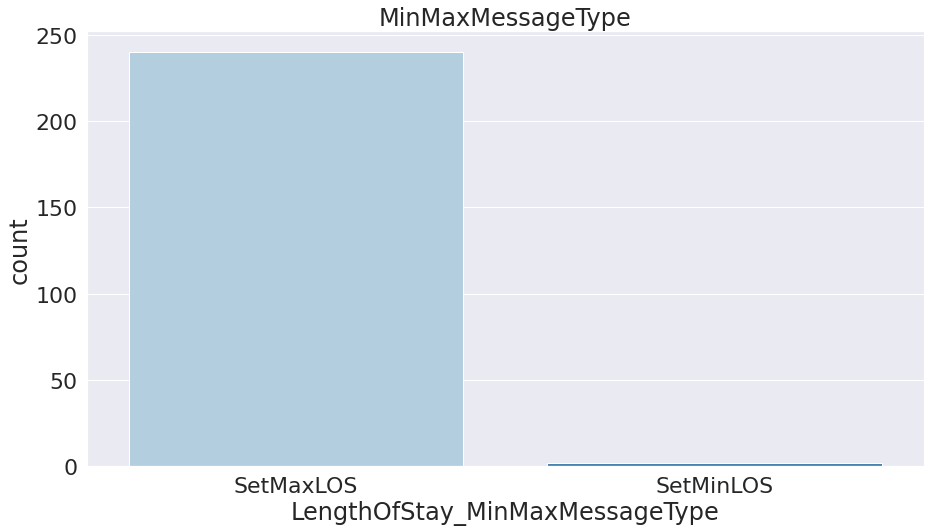

In [291]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 2)
sns.countplot(x = HotelBookingRuleNotifRQ.LengthOfStay_MinMaxMessageType, data = HotelBookingRuleNotifRQ, palette = 'Blues')
plt.title('MinMaxMessageType')
plt.show()

#### Checking null values for LengthOfStay_Time

In [292]:
HotelBookingRuleNotifRQ.LengthOfStay_Time.isna().sum()

0

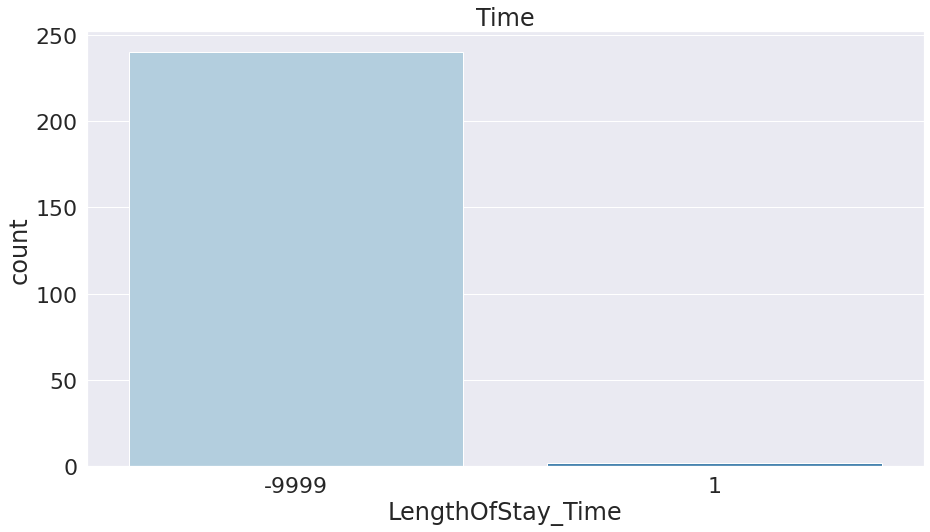

In [293]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 2)
sns.countplot(x = HotelBookingRuleNotifRQ.LengthOfStay_Time,data = HotelBookingRuleNotifRQ, palette = 'Blues')
plt.title('Time')
plt.show()

#### Checking null values for Start

In [294]:
HotelBookingRuleNotifRQ.Start.isna().sum()

0

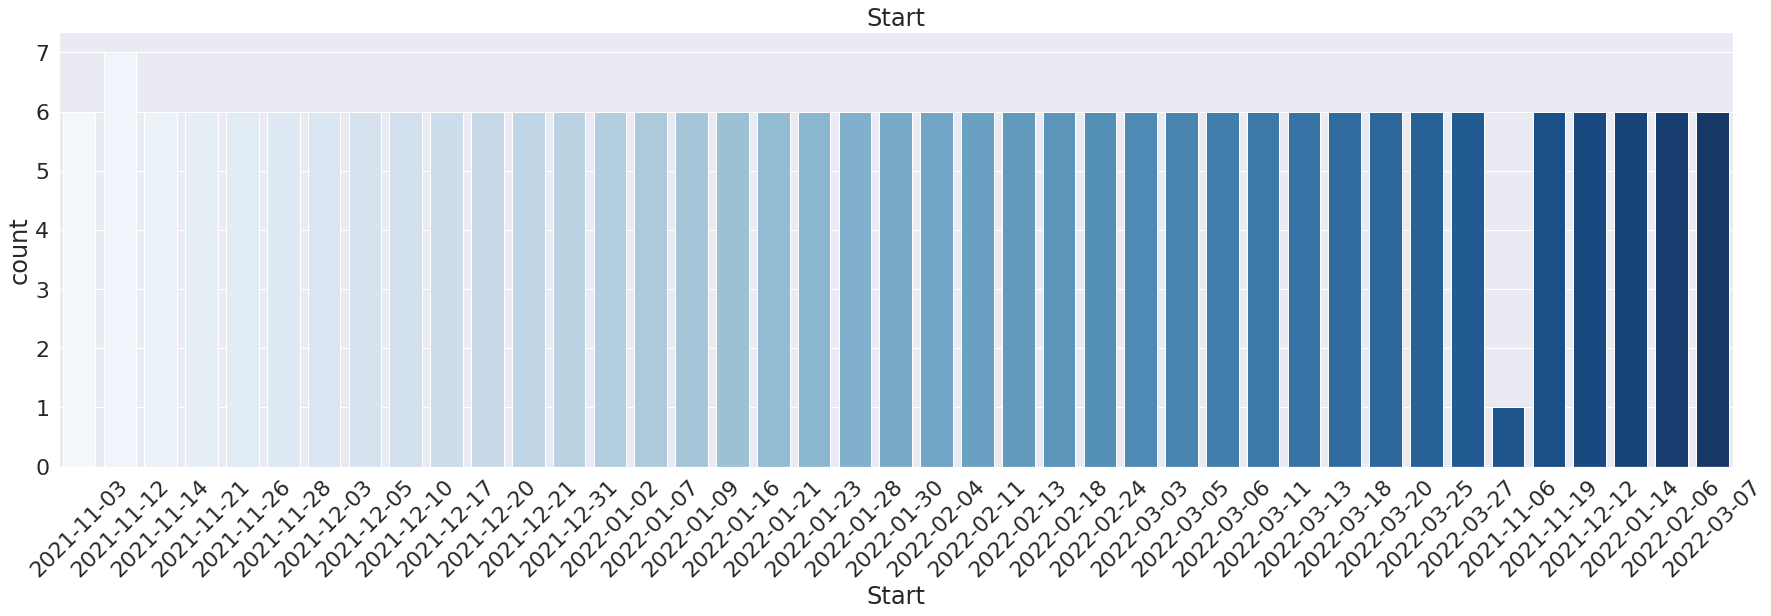

In [295]:
plt.figure(figsize=(30,8))
sns.set(font_scale = 2)
sns.countplot(x = HotelBookingRuleNotifRQ.Start, data = HotelBookingRuleNotifRQ,palette = 'Blues')
plt.xticks(rotation=45)
plt.title('Start')
plt.show()

#### Checking null values for End

In [296]:
HotelBookingRuleNotifRQ.End.isna().sum()

0

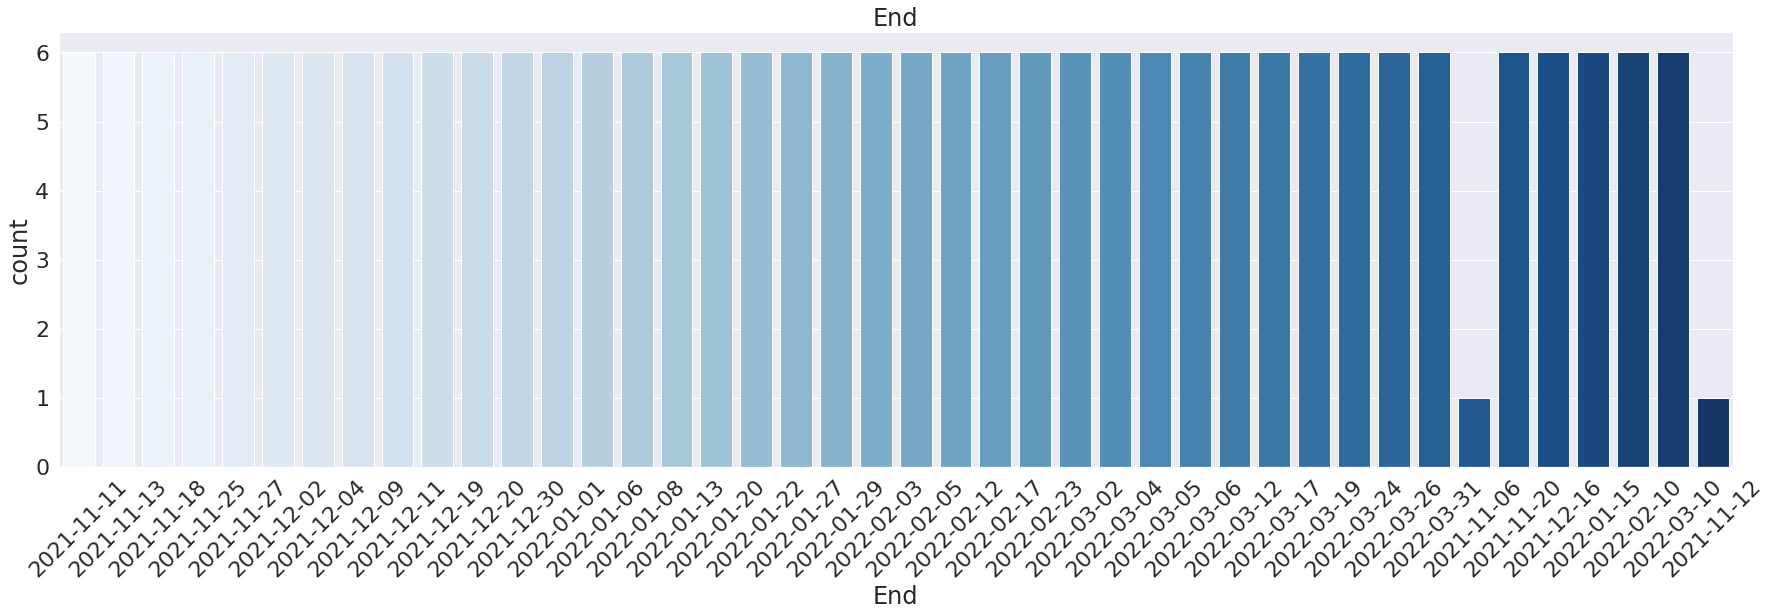

In [297]:
plt.figure(figsize=(30,8))
sns.set(font_scale = 2)
sns.countplot(x = HotelBookingRuleNotifRQ.End, data = HotelBookingRuleNotifRQ, palette = 'Blues')
plt.xticks(rotation=45)
plt.title('End')
plt.show()

In [298]:
HotelBookingRuleNotifRQ["TimeDiff"] = [x.days for x in HotelBookingRuleNotifRQ["TimeDiff"]]

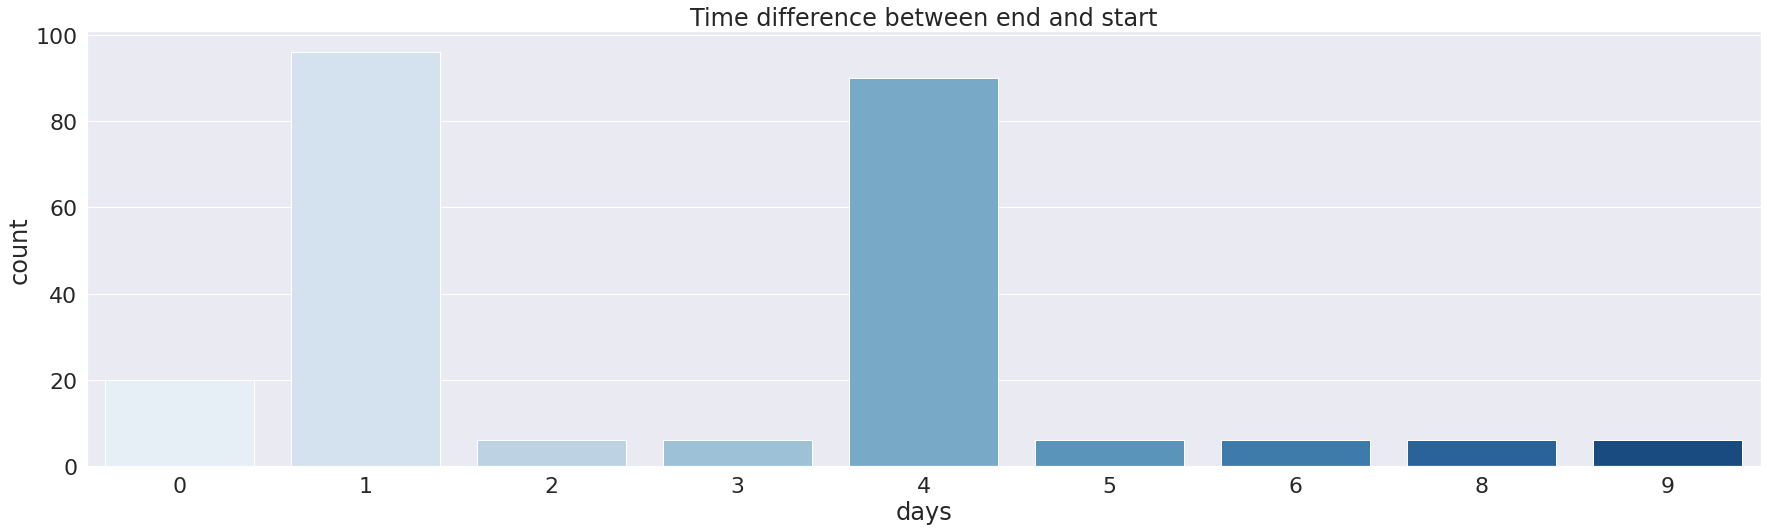

In [299]:
plt.figure(figsize=(30,8))
sns.set(font_scale = 2)
sns.countplot(x = HotelBookingRuleNotifRQ.TimeDiff, data = HotelBookingRuleNotifRQ, palette = 'Blues')
plt.title('Time difference between end and start')
plt.xlabel("days")
plt.show()